In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import pandasql as ps
import pyspark
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName('lol').getOrCreate()#создание сессии
flight_data = spark.read.csv("flights.csv", header=True, inferSchema=True)

In [3]:
#создаем представление таблицы полетов
flight_data.createOrReplaceTempView("flights")

# Анализ данных

In [14]:
#1
#Количество рейсов по месяцам

count_month = spark.sql('''SELECT MONTH,COUNT(MONTH) AS COUNT_IN_MONTH
FROM flights
GROUP BY MONTH''')

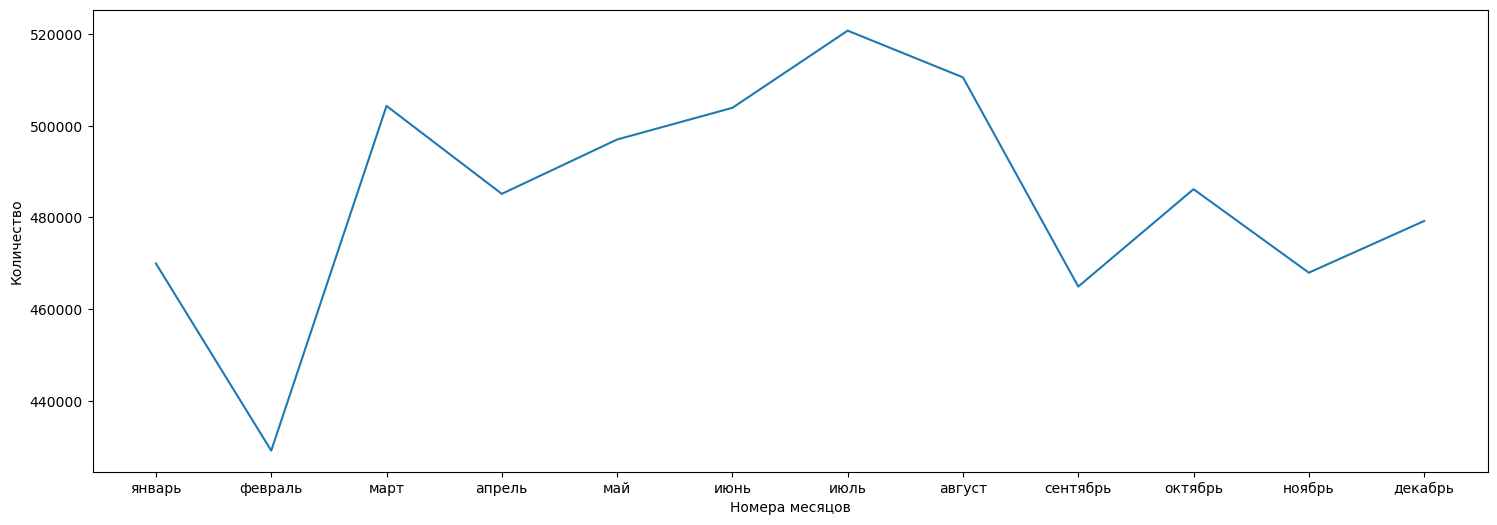

In [13]:
month_mas = [list(row) for row in count_month.collect()]
month_names = ['январь', 'февраль', 'март', 'апрель', 'май', 'июнь', 'июль', 'август', 'сентябрь', 'октябрь', 'ноябрь', 'декабрь']
plt.figure(figsize=(18,6))
plt.xlabel('Номера месяцов')
plt.ylabel('Количество')
plt.plot(month_names,[count[1] for count in month_mas])

In [8]:
print(f"Пик приходится на июль, спад приходится на февраль")

Пик приходится на июль, спад приходится на февраль


In [20]:
#2
#Количество рейсов в днях недели
count_days_week = spark.sql('''SELECT DAY_OF_WEEK DAY,COUNT(DAY_OF_WEEK) COUNT
FROM flights
GROUP BY DAY_OF_WEEK
ORDER BY DAY_OF_WEEK
''')

count_days_week.toPandas()

,DAY,COUNT
0,1,865543
1,2,844600
2,3,855897
3,4,872521
4,5,862209
5,6,700545
6,7,817764


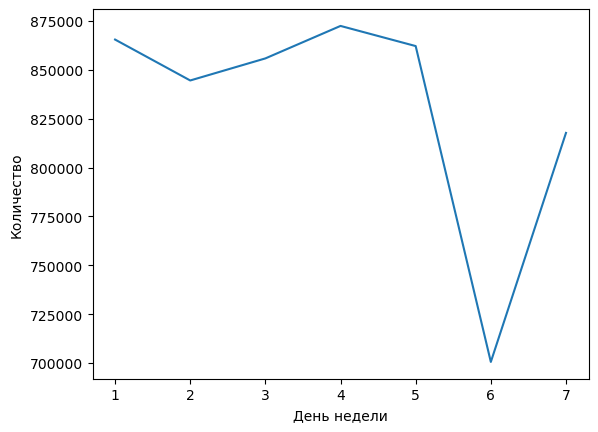

In [9]:
days_week_mas = [list(row) for row in count_days_week.collect()]
plt.xlabel("День недели")
plt.ylabel("Количество")
plt.plot([count[0] for count in days_week_mas],[count[1] for count in days_week_mas])

### Похоже на экспоненциальное распределение

In [4]:
#3
data_airports = spark.read.csv("airports.csv", header=True, inferSchema=True)
data_airports.createOrReplaceTempView("airports")
data_airports.show()

+---------+--------------------+-------------+-----+-------+--------+----------+
|IATA_CODE|             AIRPORT|         CITY|STATE|COUNTRY|LATITUDE| LONGITUDE|
+---------+--------------------+-------------+-----+-------+--------+----------+
|      ABE|Lehigh Valley Int...|    Allentown|   PA|    USA|40.65236|  -75.4404|
|      ABI|Abilene Regional ...|      Abilene|   TX|    USA|32.41132|  -99.6819|
|      ABQ|Albuquerque Inter...|  Albuquerque|   NM|    USA|35.04022|-106.60919|
|      ABR|Aberdeen Regional...|     Aberdeen|   SD|    USA|45.44906| -98.42183|
|      ABY|Southwest Georgia...|       Albany|   GA|    USA|31.53552| -84.19447|
|      ACK|Nantucket Memoria...|    Nantucket|   MA|    USA|41.25305| -70.06018|
|      ACT|Waco Regional Air...|         Waco|   TX|    USA|31.61129| -97.23052|
|      ACV|      Arcata Airport|Arcata/Eureka|   CA|    USA|40.97812|-124.10862|
|      ACY|Atlantic City Int...|Atlantic City|   NJ|    USA|39.45758| -74.57717|
|      ADK|        Adak Airp

In [21]:
#группировка по аэропорту вылета
from_city = spark.sql('''
SELECT CITY,COUNT(CITY) AS COUNT_CITY1
FROM (flights
INNER JOIN airports
ON flights.ORIGIN_AIRPORT = airports.IATA_CODE)
GROUP BY CITY
ORDER BY CITY
''')

#группировка по аэропорту прилета
to_city = spark.sql('''
SELECT CITY,COUNT(CITY) AS COUNT_CITY2
FROM (flights
INNER JOIN airports
ON flights.DESTINATION_AIRPORT = airports.IATA_CODE)
GROUP BY CITY
ORDER BY CITY
''')

from_city.createOrReplaceTempView("from_city")
to_city.createOrReplaceTempView("to_city")

#соединяем две таблицы по аэропорту сверху и находим общее количество
all_cities = spark.sql('''
SELECT from_city.CITY,(COUNT_CITY1+COUNT_CITY2) AS COUNT_ALL
FROM from_city
FULL JOIN to_city
ON from_city.CITY = to_city.CITY
ORDER BY COUNT_ALL DESC
LIMIT 10

''')

all_cities.toPandas()

,CITY,COUNT_ALL
0,Chicago,733560
1,Atlanta,693740
2,Dallas-Fort Worth,479133
3,Houston,397388
4,Denver,392065
5,Los Angeles,389369
6,New York,386806
7,San Francisco,295974
8,Phoenix,293627
9,Las Vegas,266379


In [7]:
#4
airlines_data = spark.read.csv("airlines.csv", header=True, inferSchema=True)
airlines_data.createOrReplaceTempView("airlines")

In [24]:
#соединяем flights и airlines, по коду и группируем по авиакомпании
top_airports= spark.sql('''
SELECT AIRLINE,COUNT(AIRLINE) AS COUNT_AIRLINE
FROM (SELECT airlines.AIRLINE
FROM flights
INNER JOIN airlines
ON flights.AIRLINE = airlines.IATA_CODE) 
GROUP BY AIRLINE
ORDER BY COUNT_AIRLINE DESC
LIMIT 10
''')

top_airports = top_airports.toPandas()
top_airports

,AIRLINE,COUNT_AIRLINE
0,Southwest Airlines Co.,1261855
1,Delta Air Lines Inc.,875881
2,American Airlines Inc.,725984
3,Skywest Airlines Inc.,588353
4,Atlantic Southeast Airlines,571977
5,United Air Lines Inc.,515723
6,American Eagle Airlines Inc.,294632
7,JetBlue Airways,267048
8,US Airways Inc.,198715
9,Alaska Airlines Inc.,172521


In [25]:
#компания с наибольшим количеством рейсов 
top_airports['AIRLINE'].iloc[0]

'Southwest Airlines Co.'

# Исследование данных

#### Группируем среднее задержок по аэропортам

In [27]:
#1
#1.сначала соединяем airports и flights по аэропорту вылета, выводим аэропорт и задержку вылета
#2.далее группируем по аэропорту среднее задержок и находим самую минимальную задержку
delay_airport = spark.sql('''
SELECT AIRPORT,AVG(DEPARTURE_DELAY) AS MINIMUM
FROM (SELECT AIRPORT,DEPARTURE_DELAY
FROM airports
INNER JOIN flights
ON flights.ORIGIN_AIRPORT = airports.IATA_CODE)
GROUP BY AIRPORT
ORDER BY MINIMUM
LIMIT 1
''')

delay_airport = delay_airport.toPandas()

### Аэропорт с минимальной задержкой 

In [31]:
delay_airport['AIRPORT'].iloc[0]

'Yakutat Airport'

In [35]:
#берем код выше и вычисляем среднее
delay_airports_top = spark.sql('''
SELECT AVG(MINIMUM) AS MEAN_DELAY
FROM (SELECT AIRPORT,AVG(DEPARTURE_DELAY) AS MINIMUM
FROM (SELECT AIRPORT,DEPARTURE_DELAY
FROM airports
INNER JOIN flights
ON flights.ORIGIN_AIRPORT = airports.IATA_CODE)
GROUP BY AIRPORT
ORDER BY MINIMUM
LIMIT 10)
''')

### Средняя задержка вылета для аэропортов из топ-10 по количеству рейсов

In [32]:
avg_aeroport = spark.sql('''
SELECT AIRPORT,AVG(DEPARTURE_DELAY) AS MAXIMUM
FROM (SELECT AIRPORT,DEPARTURE_DELAY
FROM airports
INNER JOIN flights
ON flights.ORIGIN_AIRPORT = airports.IATA_CODE)
GROUP BY AIRPORT
ORDER BY MAXIMUM DESC
''')

top = spark.sql('''
SELECT AIRPORT,COUNT(AIRPORT) AS CC
FROM (SELECT AIRPORT
FROM airports 
INNER JOIN flights
ON flights.ORIGIN_AIRPORT = airports.IATA_CODE)
GROUP BY AIRPORT
ORDER BY CC DESC
LIMIT 10
''')

avg_aeroport.createOrReplaceTempView("avg_aeroport")
top.createOrReplaceTempView("top")

full = spark.sql('''
SELECT AVG(MAXIMUM) AS MEAN_AIRPORTS
FROM (SELECT avg_aeroport.AIRPORT,MAXIMUM
FROM avg_aeroport
INNER JOIN top
ON avg_aeroport.AIRPORT = top.AIRPORT
ORDER BY MAXIMUM DESC) 
''')

full = full.toPandas()
full

,MEAN_AIRPORTS
0,10.717525


In [33]:
spark.sql('''
SELECT avg_aeroport.AIRPORT,MAXIMUM
FROM avg_aeroport
INNER JOIN top
ON avg_aeroport.AIRPORT = top.AIRPORT
ORDER BY MAXIMUM DESC
''').toPandas()

,AIRPORT,MAXIMUM
0,Chicago O'Hare International Airport,14.151375
1,Denver International Airport,11.836019
2,George Bush Intercontinental Airport,11.579953
3,Dallas/Fort Worth International Airport,11.528820
4,San Francisco International Airport,11.190665
5,McCarran International Airport,10.953936
6,Los Angeles International Airport,10.669969
7,Hartsfield-Jackson Atlanta International Airport,9.340695
8,Phoenix Sky Harbor International Airport,8.668676
9,Minneapolis-Saint Paul International Airport,7.255145


### Среднее из топ 10 минимальных задержек 

In [36]:
delay_airports_top.toPandas()

,MEAN_DELAY
0,-2.925396


In [6]:
#2
punct_company = spark.sql('''
SELECT IATA_CODE
FROM (SELECT IATA_CODE,RANK() OVER(ORDER BY IATA_CODE DESC) AS rank
FROM airports)
WHERE rank = 234
''')

In [7]:
punct_company.show()

+---------+
|IATA_CODE|
+---------+
|      DIK|
+---------+



### Мой аэропорт

In [15]:
my_air = spark.sql('''
SELECT AIRPORT
FROM airports
WHERE IATA_CODE='DIK'
''')

print(f"Мой аэропорт: {[list(row)[0] for row in my_air.collect()][0]}")

Мой аэропорт: Dickinson Theodore Roosevelt Regional Airport


### Соединяем airlines и flights по airline, группируем по авиакомпании (берем среднее), и выводим компанию и минимальную задержку прилета

In [37]:
#1.соединяем airlines и flights по коду,в условии где аэропорт прилета равен моему аэропорту
#2.группируем средние по авиакомпаниям и выводим все с самой минимальной задержкой прилета
company_all = spark.sql('''
SELECT  AIRLINE,AVG(ARRIVAL_DELAY) AS MEAN_DELAY
FROM (SELECT airlines.AIRLINE,DESTINATION_AIRPORT,ARRIVAL_DELAY
FROM airlines
INNER JOIN flights
ON airlines.IATA_CODE = flights.AIRLINE
WHERE DESTINATION_AIRPORT = "DIK")
GROUP BY AIRLINE
ORDER BY MEAN_DELAY
LIMIT 1
''')

company_all.toPandas()

,AIRLINE,MEAN_DELAY
0,Skywest Airlines Inc.,-8.646259


### Аэропорт с самым большим временем на взлетной и посадочной полосе 

In [38]:
#3
#TAXI_OUT - руление самолета когда он взлетает, TAXI_IN - руление самолета когда его сажают

#Под рулением понимается движение самолета по взлетно-посадочной полосе
#группирование среднего времен взлета по аэропорту 
air_airplane_out = spark.sql('''
SELECT AIRPORT,AVG(TAXI_OUT) AS MEAN_TAXI_OUT
FROM (SELECT TAXI_OUT,ORIGIN_AIRPORT,AIRPORT
FROM flights
INNER JOIN airports
ON flights.ORIGIN_AIRPORT = airports.IATA_CODE)
GROUP BY AIRPORT
ORDER BY MEAN_TAXI_OUT DESC
''')

#группирование среднего времен прилета по аэропорту 
air_airplane_in = spark.sql('''
SELECT AIRPORT,AVG(TAXI_IN) AS MEAN_TAXI_IN
FROM (SELECT TAXI_IN,DESTINATION_AIRPORT,AIRPORT
FROM flights
INNER JOIN airports
ON flights.DESTINATION_AIRPORT = airports.IATA_CODE)
GROUP BY AIRPORT
ORDER BY MEAN_TAXI_IN DESC
''')

air_airplane_out.createOrReplaceTempView("air_airplane_out")
air_airplane_in.createOrReplaceTempView("air_airplane_in")


#соединение верхних таблиц по аэроопорту и нахождение суммы taxi
air_airplane = spark.sql('''
SELECT air_airplane_out.AIRPORT,(MEAN_TAXI_IN+MEAN_TAXI_OUT) AS TAXI
FROM air_airplane_out
INNER JOIN air_airplane_in
ON air_airplane_out.AIRPORT = air_airplane_in.AIRPORT
ORDER BY TAXI DESC
LIMIT 10
''')

air_airplane.toPandas()

,AIRPORT,TAXI
0,John F. Kennedy International Airport (New Yor...,35.752036
1,LaGuardia Airport (Marine Air Terminal),35.621315
2,Chicago O'Hare International Airport,32.757726
3,Newark Liberty International Airport,29.926073
4,Charlotte Douglas International Airport,29.281539
5,Dallas/Fort Worth International Airport,28.805402
6,Los Angeles International Airport,28.661365
7,Philadelphia International Airport,28.407234
8,Miami International Airport,27.604314
9,Gen. Edward Lawrence Logan International Airport,27.079949


In [38]:
[list(row)[0] for row in air_airplane.collect()][0]

'John F. Kennedy International Airport\xa0(New York International Airport)'